In [1]:
!pip install --upgrade --quiet transformers datasets accelerate peft bitsandbytes pillow --no-deps

import transformers, accelerate, peft
print("transformers:", transformers.__version__)
print("accelerate:   ", accelerate.__version__)
print("peft:         ", peft.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.1/362.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.1/411.1 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 91.7 MB/s eta 0:00:00


2025-05-16 09:57:49.182037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747389469.390072      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747389469.447090      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


transformers: 4.51.3
accelerate:    1.7.0
peft:          0.15.2


In [2]:
from PIL import Image, ImageOps

class PadTo256:
    def __init__(self, fill=255):
        # fill=255 gives white; for RGB you could also do fill=(255,255,255)
        self.fill = fill

    def __call__(self, img: Image.Image) -> Image.Image:
        # 1) make a copy so we don't clobber the original
        img = img.copy()

        # 2) thumbnail will scale **in-place** so that both width & height <= (256,256)
        #    preserving aspect ratio
        img.thumbnail((256, 256), Image.BILINEAR)

        w, h = img.size
        # 3) compute how much padding is needed on each side
        pad_left   = (256 - w) // 2
        pad_top    = (256 - h) // 2
        pad_right  = 256 - w - pad_left
        pad_bottom = 256 - h - pad_top

        # 4) expand with white border
        return ImageOps.expand(img, border=(pad_left, pad_top, pad_right, pad_bottom),
                               fill=self.fill)


# instantiate once:
RESIZE = PadTo256(fill=(255,255,255))   # white pad
# in collate_fn, just:

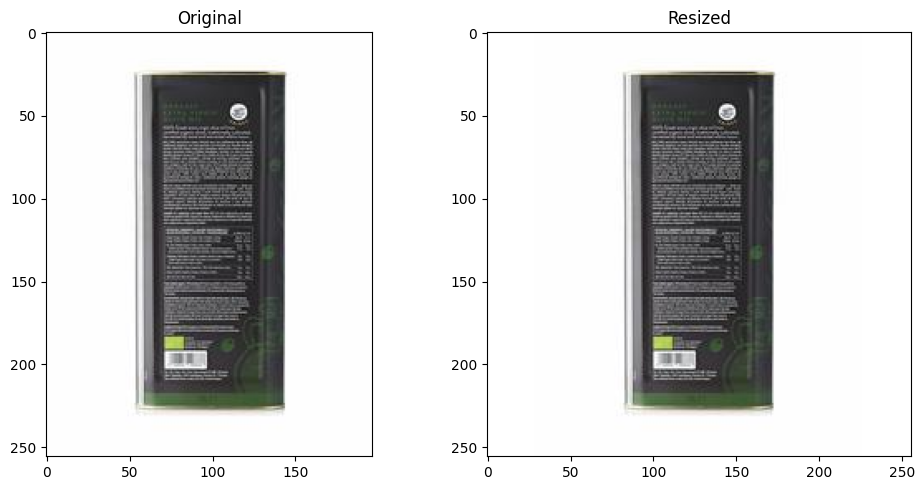

In [3]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

root = '/kaggle/input/abo-small/images/small'

# 1. Pick random subfolder and file
subdir = random.choice(os.listdir(root))
subpath = os.path.join(root, subdir)
fname  = random.choice(os.listdir(subpath))
img_path = os.path.join(subpath, fname)

# 2. Load original
orig = Image.open(img_path)

# 3. Apply your RESIZE transform
resized = RESIZE(orig.copy())

# 4. Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(orig)
axes[0].set_title("Original")

axes[1].imshow(resized)
axes[1].set_title("Resized")

plt.tight_layout()
plt.show()


In [4]:
# 0) Install & imports
# !pip install --upgrade transformers accelerate peft datasets pillow --no-deps

import os, warnings, torch
from PIL import Image
from datasets import load_dataset, concatenate_datasets, ClassLabel
from transformers import (
    AutoProcessor,
    Qwen2VLForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model

os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore")

# pick your device once
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Load & filter CSVs
RAW_PATHS = {
    "train":      "/kaggle/input/vr-data-curation1/qa_dataset2.csv",
    "validation": "/kaggle/input/vr-data-curation2/qa_dataset2.csv",
}
raw = load_dataset("csv", data_files=RAW_PATHS)
for split in raw:
    raw[split] = raw[split].filter(lambda ex: bool((ex.get("answer") or "").strip()))

full = concatenate_datasets([raw["train"], raw["validation"]])
types = full.unique("product_type"); types.sort()
full = full.cast_column("product_type", ClassLabel(names=types))

full = full.shuffle(seed=42)

splits = full.shuffle(seed=42).train_test_split(test_size=0.10, seed=42)
train_ds, val_ds = splits["train"], splits["test"]

def is_large_enough(ex):
    img = Image.open(f"/kaggle/input/abo-small/images/small/{ex['path']}").convert("RGB")
    return img.width >= 28 and img.height >= 28

train_ds = train_ds.filter(is_large_enough)
val_ds   = val_ds.filter(is_large_enough)

# train_ds = train_ds.train_test_split(test_size=1000, seed=42)["test"]
val_ds   = val_ds.shuffle(seed = 42).train_test_split(test_size=0.5,  seed=42)["test"]

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/66144 [00:00<?, ? examples/s]

Filter:   0%|          | 0/66144 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/132287 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/132287 [00:00<?, ? examples/s]

Filter:   0%|          | 0/119058 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13229 [00:00<?, ? examples/s]

Train: 118938, Val: 6609


In [5]:
# 2) Processor & model in FP16
processor = AutoProcessor.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    trust_remote_code=True,
    min_pixels=224 * 224, #Since abo images in 256,we tried to keep a little lower than that.
    max_pixels=1280*28*28,
)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    trust_remote_code=True,
    torch_dtype=torch.float16
).to(device)

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.4k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

In [6]:
# 3) Attach LoRA (parameters already FP16)
peft_config = LoraConfig(
    inference_mode=False,
    r=16, lora_alpha=32, lora_dropout=0.05,
    target_modules=[
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    "down_proj",
    "lm_head",
]
)
peft_model = get_peft_model(model, peft_config).to(device)

# 4) Preprocessing fn
def preprocess_batch(examples):
    enc = processor.tokenizer(
        examples["question"], truncation=True, max_length=128
    )
    tgt = processor.tokenizer(
        examples["answer"],   truncation=True, max_length=32
    )
    return {
        "path": examples["path"],
        "input_ids": enc.input_ids,
        "attention_mask": enc.attention_mask,
        "labels": tgt.input_ids,
        "question": examples["question"],
    }

tokenized_train = train_ds.map(preprocess_batch, batched=True)
tokenized_val   = val_ds.map(preprocess_batch,   batched=True)
for ds in (tokenized_train, tokenized_val):
    ds.set_format(
        type="torch",
        columns=["path","input_ids","attention_mask","labels","question"]
    )

# 5) Collator (unchanged)
from PIL import Image, ImageOps

class PadTo256:
    def __init__(self, fill=255):
        # fill=255 gives white; for RGB you could also do fill=(255,255,255)
        self.fill = fill

    def __call__(self, img: Image.Image) -> Image.Image:
        # 1) make a copy so we don't clobber the original
        img = img.copy()

        # 2) thumbnail will scale **in-place** so that both width & height <= (256,256)
        #    preserving aspect ratio
        img.thumbnail((256, 256), Image.BILINEAR)

        w, h = img.size
        # 3) compute how much padding is needed on each side
        pad_left   = (256 - w) // 2
        pad_top    = (256 - h) // 2
        pad_right  = 256 - w - pad_left
        pad_bottom = 256 - h - pad_top

        # 4) expand with white border
        return ImageOps.expand(img, border=(pad_left, pad_top, pad_right, pad_bottom),
                               fill=self.fill)


# instantiate once:
RESIZE = PadTo256(fill=(255,255,255))   # white pad
# in collate_fn, just:

from pathlib import Path
from PIL import Image
import torch

IMAGE_DIR = Path("/kaggle/input/abo-small/images/small")

def collate_fn(batch):
    questions = []
    labels_list = []
    images = []
    skip_count = 0

    # Single pass: pre‐check, open, resize, and collect
    for ex in batch:
        img_path = IMAGE_DIR / ex.get("path", "")
        lbl_ids  = ex.get("labels")
        q_text   = ex.get("question")
        if lbl_ids is None or q_text is None or not img_path.is_file():
            skip_count += 1
            continue

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception:
            skip_count += 1
            continue

        images.append(RESIZE(img))
        questions.append(q_text)
        labels_list.append(torch.tensor(lbl_ids, dtype=torch.long))

    if skip_count:
        print(f"Skipping {skip_count} images")

    # Build the “chat” samples in one comprehension
    samples = [
        [
              {
                "role": "system",
                "content": [
                  {
                    "type": "text",
                    "text": "You are a visual question answering model. " 
                            "Given the image and the user’s question, "
                            "answer in exactly one word."
                  }
                ]
              },
              {
                "role": "user",
                "content": [
                  {"type": "image", "image": img},
                  {"type": "text",  "text":  f"{q}"}
                ]
              }
            ]
        for img, q in zip(images, questions)
    ]

    # One pass for templating + tokenization
    prompts = processor.apply_chat_template(
        samples,
        tokenize=False,
        add_generation_prompt=True
    )
    proc = processor(
        text=prompts,
        images=[[img] for img in images],
        padding="longest",
        truncation=True,
        return_tensors="pt",
    )

    # Vectorized label masking
    input_ids = proc.input_ids
    labels = input_ids.new_full(input_ids.shape, -100)
    for i, lbl in enumerate(labels_list):
        labels[i, -lbl.size(0):] = lbl

    return {
        "pixel_values":   proc.pixel_values,
        "image_grid_thw": proc.image_grid_thw,
        "input_ids":      input_ids,
        "attention_mask": proc.attention_mask,
        "labels":         labels,
    }

Map:   0%|          | 0/118938 [00:00<?, ? examples/s]

Map:   0%|          | 0/6609 [00:00<?, ? examples/s]

In [7]:
# 6) Training args & trainer with AMP
training_args = Seq2SeqTrainingArguments(
    output_dir="qwen2vl_fp16_peft",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=8,
    # num_train_epochs=3,
    # fp16=True,                      # ← enable mixed precision
    bf16 = True,
    max_steps = 16000,
    learning_rate=1e-5,
    weight_decay=1e-6,
    warmup_steps=5,
    lr_scheduler_type="cosine", 

    eval_strategy="steps",
    eval_steps=4000,
    save_steps=4000,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    predict_with_generate=True,

    logging_steps=4000,
    report_to=["none"],

    remove_unused_columns=False,
    label_names=["labels"],
    dataloader_num_workers=4,
    dataloader_prefetch_factor=2,
    dataloader_pin_memory=True,
    gradient_checkpointing=False,
    dataloader_drop_last=True,
    # eval_dataloader_drop_last=True
    # drop_last = True,
)

from torch.utils.data import DataLoader
from transformers import Seq2SeqTrainer

class CustomTrainer(Seq2SeqTrainer):
    def get_eval_dataloader(self, eval_dataset=None):
        eval_dataset = eval_dataset if eval_dataset is not None else self.eval_dataset
        return DataLoader(
            eval_dataset,
            batch_size=self.args.per_device_eval_batch_size,
            shuffle=False,
            collate_fn=self.data_collator,
            drop_last=True,                          # ← drop that last partial batch
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
        )


trainer = Seq2SeqTrainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=collate_fn,
    tokenizer=processor.tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

# 7) Launch training
trainer.train()

Step,Training Loss,Validation Loss
4000,1.554400,1.211217
8000,1.101000,1.061039
12000,0.956900,1.007091
16000,0.922100,0.996831


TrainOutput(global_step=16000, training_loss=1.1336075897216797, metrics={'train_runtime': 40453.9306, 'train_samples_per_second': 6.328, 'train_steps_per_second': 0.396, 'total_flos': 3.8694979505985946e+17, 'train_loss': 1.1336075897216797, 'epoch': 2.152562895197094})

In [8]:
# 8) Save the fine-tuned LoRA adapters + the base model + processor/tokenizer
save_dir = "/kaggle/working/"

# 8a) LoRA adapters only
peft_model.save_pretrained(f"{save_dir}/lora_adapters_fp16")

# 8b) Base model (FP16 weights)
# peft_model.base_model.save_pretrained(f"{save_dir}/base_model_fp16")

# 8c) Processor / tokenizer
processor.save_pretrained(f"{save_dir}/processor")

[]

In [9]:
from peft import PeftModel

# assuming `peft_model` is your PeftModel-wrapped model:

# 1. Merge the adapters into the base model and unload the adapter code
merged_model = peft_model.merge_and_unload()

# 2. Save the merged model (no more LoRA hooks, just a standard Hugging Face model)
merged_model.save_pretrained(f"{save_dir}/merged_model_fp16")